A notebook which contains an evaluation of the SalishSeaCast model within PugetSound for the year 2019. More specifically, it compares Observed data on chlorophyll concentrations collected from bottle data and compares it to various model phytoplankon outputs. This evaluation includes scatter plots and 2d histograms visualizing the similarity of observed and model data as well as tables of evaluation statistics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
year=2009
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2009

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [5]:
dfTime=pd.read_excel('/ocean/eolson/MEOPAR/obs/WADE/WDE_Data/OlsonSuchyAllen_UBC_PDR_P003790-010721.xlsx',
                    engine='openpyxl',sheet_name='EventDateTime')

In [6]:
## duplicate Station/Date entries with different times seem to be always within a couple of hours, 
# so just take the first (next cell)
test=dfTime.groupby(['FlightDate','SiteCode'])['TimeDown \n(Local - PST or PDT)'].count()

In [7]:
# drop duplicate rows
dfTime.drop_duplicates(subset=['FlightDate','SiteCode'],keep='first',inplace=True)
print(dfTime.keys())

Index(['FlightYear', 'FlightMonth', 'FlightDate', 'SiteCode', 'Sampled',
       'TimeDown \n(Local - PST or PDT)', 'FieldComment'],
      dtype='object')


In [8]:
dfTime['dtPac']=[dt.datetime.combine(idate, itime) for idate, itime \
         in zip(dfTime['FlightDate'],dfTime['TimeDown \n(Local - PST or PDT)'])]
dfTime['dtUTC']=[et.pac_to_utc(ii) for ii in dfTime['dtPac']]

In [9]:
# PROCESS STATION LOCATION INFO (based on Parker's code)
sta_fn='/ocean/eolson/MEOPAR/obs/WADE/WDE_Data/OlsonSuchyAllen_UBC_PDR_P003790-010721.xlsx'
sheetname='Site Info'
sta_df =pd.read_excel(sta_fn,engine='openpyxl',sheet_name=sheetname)
sta_df.dropna(how='any',subset=['Lat_NAD83 (deg / dec_min)','Long_NAD83 (deg / dec_min)','Station'],inplace=True)
sta_df = sta_df.set_index('Station')
# get locations in decimal degrees
for sta in sta_df.index:
    lat_str = sta_df.loc[sta, 'Lat_NAD83 (deg / dec_min)']
    lat_deg = float(lat_str.split()[0]) + float(lat_str.split()[1])/60
    sta_df.loc[sta,'Lat'] = lat_deg
    #
    lon_str = sta_df.loc[sta, 'Long_NAD83 (deg / dec_min)']
    lon_deg = float(lon_str.split()[0]) + float(lon_str.split()[1])/60
    sta_df.loc[sta,'Lon'] = -lon_deg    
sta_df.pop('Lat_NAD83 (deg / dec_min)');
sta_df.pop('Long_NAD83 (deg / dec_min)');

In [10]:
fn='/ocean/eolson/MEOPAR/obs/WADE/WDE_Data/OlsonSuchyAllen_UBC_PDR_P003790-010721.xlsx'
sheetname='LabChlaPheo'
chlPheo =pd.read_excel(fn,engine='openpyxl',sheet_name=sheetname)

In [11]:
chlPheo.dropna(how='any',subset=['Date','Station','SamplingDepth'],inplace=True)

In [12]:
# average over replicates
chlPheo2=pd.DataFrame(chlPheo.groupby(['Date','Station','SamplingDepth'],as_index=False).mean())

In [13]:
# join to station info (lat/lon)
chlPheo3=pd.merge(left=sta_df,right=chlPheo2,how='right',
                 left_on='Station',right_on='Station')

In [14]:
# join to date/time
dfTime['dtUTC']=[et.pac_to_utc(dt.datetime.combine(idate,itime)) for idate,itime in \
                zip(dfTime['FlightDate'],dfTime['TimeDown \n(Local - PST or PDT)'])]
dfTime2=dfTime.loc[:,['FlightDate','SiteCode','dtUTC']]
chlPheoFinal=pd.merge(left=chlPheo3,right=dfTime2,how='left',
                      left_on=['Date','Station'],right_on=['FlightDate','SiteCode'])
chlPheoFinal['Z']=chlPheoFinal['SamplingDepth']

In [15]:
len(chlPheoFinal),len(chlPheo3),len(dfTime2)

(11469, 11469, 5186)

In [16]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
filemap={'diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T'}
fdict={'ptrc_T':1,'grid_T':1}

In [17]:
data_Phea=et.matchData(chlPheoFinal,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain


In [40]:
def byDepth(data,ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(data,datreg,ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(data,datstat,ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                        cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(title='Stations',title_fontsize=20,handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def hist2d(data,ax,obsvar,modvar,lims,fontsize=12):
    ax.plot((-250,250),(-250,250),'k-',alpha=.2)
    ii=(~np.isnan(data[obsvar]))&(~np.isnan(data[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(data.loc[ii,[obsvar]].values.flatten(),
                                      data.loc[ii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps

def bySeason_hist2d(seaons,ax,obsvar,modvar,lims):
    for axj in ax:
        for axi in axj:
            axi.plot(lims,lims,'k-')
            axi.set_xlim(lims)
            axi.set_ylim(lims)
            axi.set_aspect(1)
            axi.set_xlabel('Obs')
            axi.set_ylabel('Model')
    jp=hist2d(seaons[0],ax[0][0],obsvar,modvar,lims)
    ax[0][0].set_title('Jan-Mar')
    jp=hist2d(seaons[1],ax[0][1],obsvar,modvar,lims)
    ax[0][1].set_title('Apr')
    jp=hist2d(seaons[2],ax[1][0],obsvar,modvar,lims)
    ax[1][0].set_title('May-Aug')
    jp=hist2d(seasons[3],ax[1][1],obsvar,modvar,lims)
    ax[1][1].set_title('Sep-Dec')
    return 

def bySeason(seaons,ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],seaons[0],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],seaons[1],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],seaons[2],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],seasons[3],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [41]:
def multi_station_graph(data,datstat,figrange,obsvar,modvar,regions,down=6,figsize=(14,40)):
    ''' A function that creates a series of scatter plots and maps for each region
    
    :arg figrange: A pair of values that will decide the range of the graph. Should always
                    should always be larger than the maximum value of the variable.
    :type : tuple
                    
    :arg obsvar,modvar: The name of the observed and model variables you wish to compare to each other.
    :type :string
    
    :are regions: The names of all of the basins you wish to look at 
    :type : list of strings
    
    :arg down: A number which should be equal to the number of regions you are looking at
    :type : integer
    
    :arg figsize: a pair of values that decide the size of the entire figure
    '''
    fig, ax = plt.subplots(down,2,figsize = figsize)
    for d,r in zip(range(down),regions):
        ps=byStation(data,datstat,ax[d][0],obsvar,modvar,figrange,r)
        ax[d][0].set_title(f'{obsvar} ($\mu$M) in {r} by Station');

        with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
            viz_tools.plot_coastline(ax[d][1], grid, coords = 'map',isobath=.1)

        for ind, istation in enumerate(data[data['Basin'] == r].Station.unique()):
            ax[d][1].plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                color = colors[ind], label=istation)
        ax[d][1].set_ylim(47, 49)
        ax[d][1].legend(bbox_to_anchor=[1,.6,0,0])
        ax[d][1].set_xlim(-124, -122);
        ax[d][1].set_title(f'Observation Locations for {r}');

def logt(x):
    return np.log10(x+.001)

In [42]:
#Adding extra columns to assist in analysis.
data_Phea['log_Chl']=logt(data_Phea['Chla_Lab'])
data_Phea['log_mod_diatoms']=logt(data_Phea['mod_diatoms']*1.8)
data_Phea['log_mod_ciliates']=logt(data_Phea['mod_ciliates']*1.8)
data_Phea['log_mod_flagellates']=logt(data_Phea['mod_flagellates']*1.8)
data_Phea['mod_Chl']=((data_Phea['mod_diatoms']*1.8)+(data_Phea['mod_ciliates']*1.8)+(data_Phea['mod_flagellates']*1.8))
data_Phea['log_mod_Chl']=logt((data_Phea['mod_diatoms']*1.8)+(data_Phea['mod_ciliates']*1.8)+(data_Phea['mod_flagellates']*1.8))

# defning a dictionary that brakes the data down by individual stations
datstat_Phea=dict()
for ind, istation in enumerate(data_Phea.Station.unique()):
    datstat_Phea[istation]=data_Phea.loc[data_Phea.Station == istation]

datreg_Phea=dict()
for iregion in data_Phea.Basin.unique():
    datreg_Phea[iregion] = data_Phea.loc[data_Phea.Basin==iregion] 

In [43]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz_Phea=(data_Phea.Z<15)
JFM_Phea=data_Phea.loc[iz_Phea&(data_Phea.dtUTC<=dt.datetime(year,4,1)),:]
Apr_Phea=data_Phea.loc[iz_Phea&(data_Phea.dtUTC<=dt.datetime(year,5,1))&(data_Phea.dtUTC>dt.datetime(year,4,1)),:]
MJJA_Phea=data_Phea.loc[iz_Phea&(data_Phea.dtUTC<=dt.datetime(year,9,1))&(data_Phea.dtUTC>dt.datetime(year,5,1)),:]
SOND_Phea=data_Phea.loc[iz_Phea&(data_Phea.dtUTC>dt.datetime(year,9,1)),:]

In [44]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs_Phea=OrderedDict({'z < 15 m':data_Phea.loc[data_Phea.Z<15],
                      '15 m < z < 22 m':data_Phea.loc[(data_Phea.Z>=15)&(data_Phea.Z<22)],
                      'z >= 22 m':data_Phea.loc[data_Phea.Z>=22],
                      'z > 50 m':data_Phea.loc[data_Phea.Z>50],
                      'all':data_Phea,
                      'z < 15 m, JFM':JFM_Phea,
                      'z < 15 m, Apr':Apr_Phea,
                      'z < 15 m, MJJA':MJJA_Phea,
                      'z < 15 m, SOND': SOND_Phea,})
for iregion in data_Phea.Basin.unique():
    statsubs_Phea[iregion]=datreg_Phea[iregion]
statsubs_Phea.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Strait of Juan de Fuca', 'Hood Canal Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'South Basin'])

## Map of observation locations in each basin

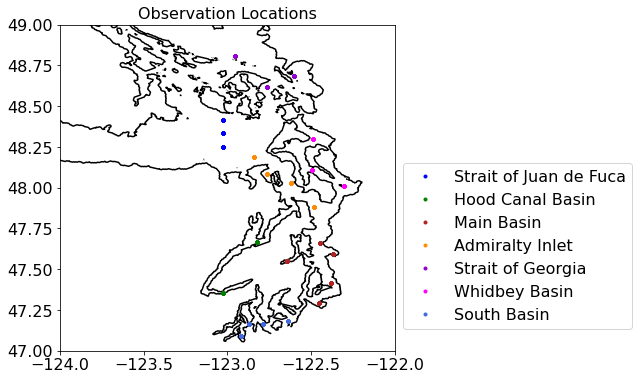

In [62]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data_Phea.Basin.unique()):
    ax.plot(datreg_Phea[iregion]['Lon'], datreg_Phea[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Chlorophyll

In [63]:
data_Phea.columns

Index(['Station', 'Desig', 'Descrip', 'Basin', '*Max_Depth', 'Lat', 'Lon',
       'Date', 'SamplingDepth', 'CTD Cast Rep', 'Chla_ResultID', 'Chla_Lab',
       'Chla_QC', 'Chla_QA', 'Chla_SampleFieldReplicateNumber',
       'Pheo_ResultID', 'Pheo_Lab', 'Pheo_QC', 'Pheo_QA',
       'Pheo_SampleFieldReplicateNumber', 'FlightDate', 'SiteCode', 'dtUTC',
       'Z', 'j', 'i', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'k',
       'log_Chl', 'log_mod_diatoms', 'log_mod_ciliates', 'log_mod_flagellates',
       'mod_Chl', 'log_mod_Chl'],
      dtype='object')

# Observed Chlorophyll vs Model Phytoplankton

In [64]:
#Setting variables for Chlorophyll.
obsvar='Chla_Lab'
modvar='mod_diatoms'
seasons=[JFM_Phea,Apr_Phea,MJJA_Phea,SOND_Phea]

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [65]:
statsDict_Chl={year:dict()}
statsDict_Chl[year]['Diatoms']=OrderedDict()
for isub in statsubs_Phea:
    statsDict_Chl[year]['Diatoms'][isub]=dict()
    var=statsDict_Chl[year]['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Phea[isub].loc[:,[obsvar]], 
                                                                     statsubs_Phea[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Diatoms'],level='Subset',suborder=list(statsubs_Phea.keys()))
tbl

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Phea)]')

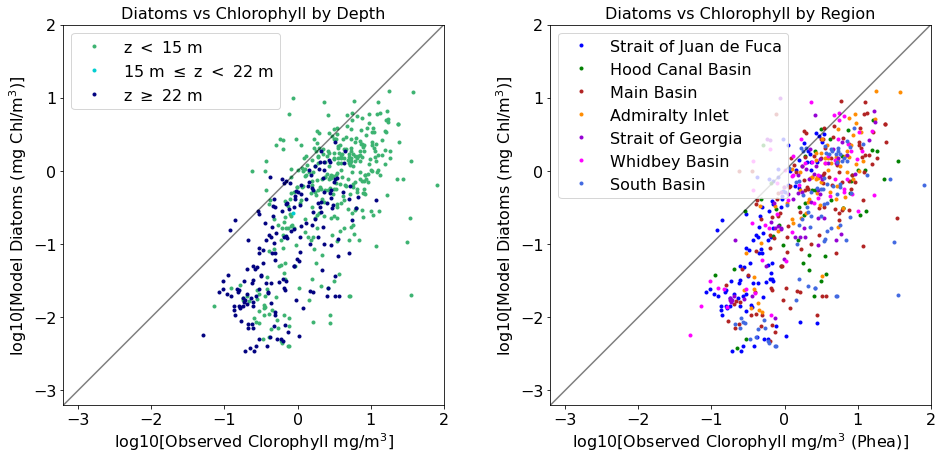

In [66]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_Phea,ax[0],obsvar,modvar,mv)
ax[0].set_title('Diatoms vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=byRegion(data_Phea,datreg_Phea,ax[1],obsvar,modvar,mv)
ax[1].set_title('Diatoms vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]') 

### Model vs observed comparisons for multiple seasons

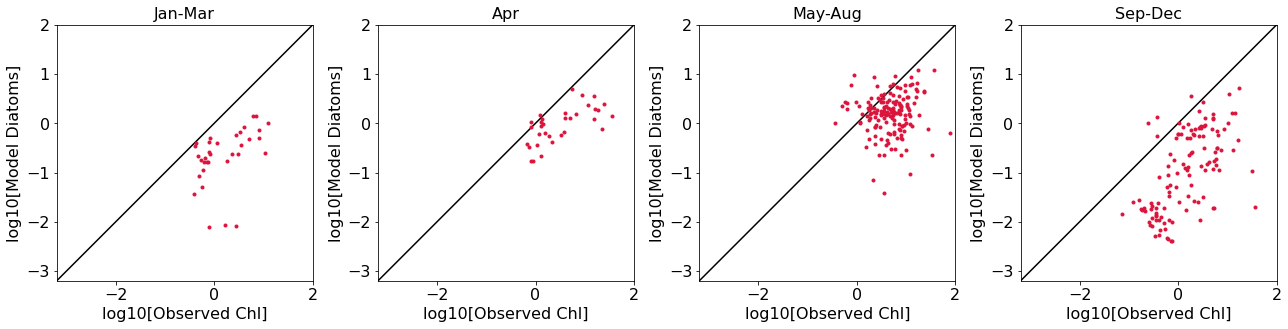

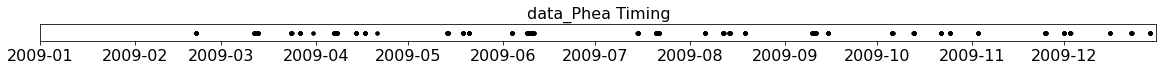

In [67]:
seasons=[JFM_Phea,Apr_Phea,MJJA_Phea,SOND_Phea]
fig, ax = plt.subplots(1,4,figsize = (18,5))
bySeason(seasons,ax,obsvar,modvar,mv)
for i in range(4):
        ax[i].set_ylabel('log10[Model Diatoms]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Phea.dtUTC,np.ones(np.shape(data_Phea.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Phea Timing')
ax.yaxis.set_visible(False)

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [68]:
obsvar='Chla_Lab'
modvar='mod_ciliates'

statsDict_Chl[year]['Ciliates']=OrderedDict()
for isub in statsubs_Phea:
    statsDict_Chl[year]['Ciliates'][isub]=dict()
    var=statsDict_Chl[year]['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Phea[isub].loc[:,[obsvar]], 
                                                                     statsubs_Phea[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Ciliates'],level='Subset',suborder=list(statsubs_Phea.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Phea)]')

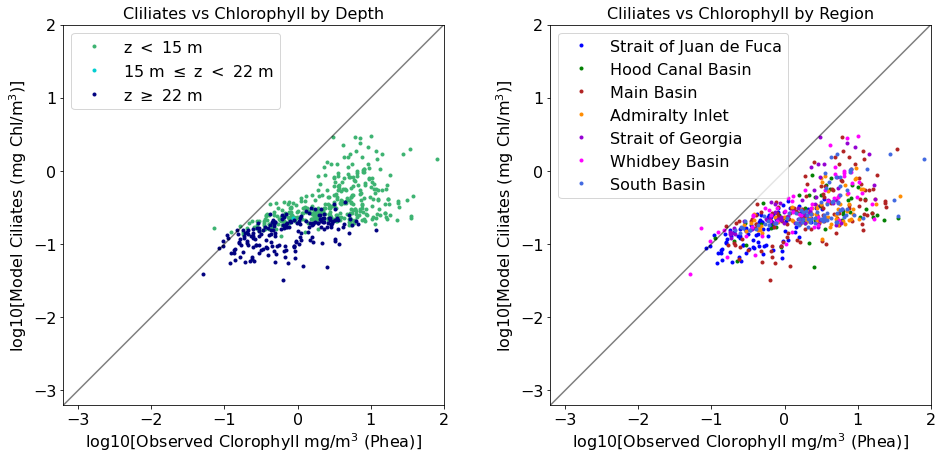

In [69]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_Phea,ax[0],obsvar,modvar,mv)
ax[0].set_title('Cliliates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]')  

ps,l=byRegion(data_Phea,datreg_Phea,ax[1],obsvar,modvar,mv)
ax[1].set_title('Cliliates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]') 

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

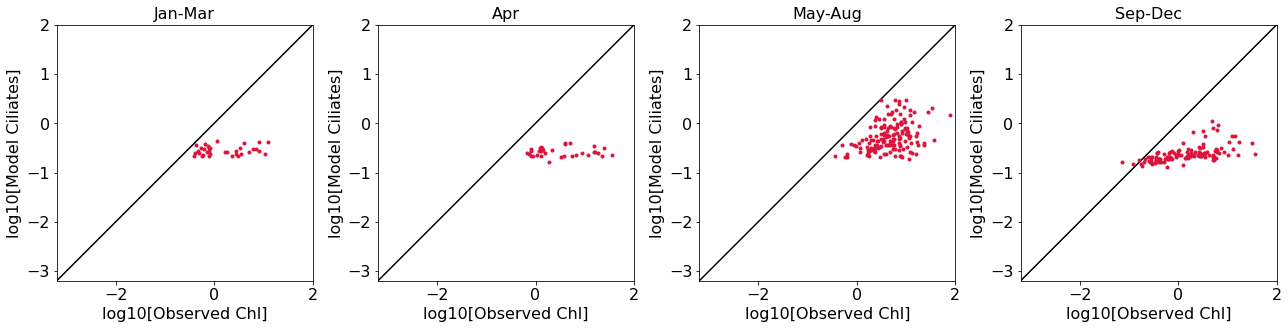

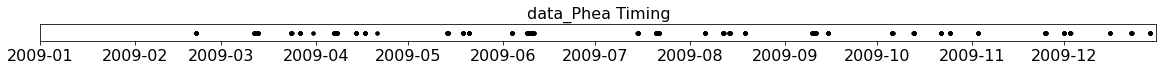

In [70]:
seasons=[JFM_Phea,Apr_Phea,MJJA_Phea,SOND_Phea]
fig, ax = plt.subplots(1,4,figsize = (18,5))
bySeason(seasons,ax,obsvar,modvar,mv)
for i in range(4):
        ax[i].set_ylabel('log10[Model Ciliates]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Phea.dtUTC,np.ones(np.shape(data_Phea.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Phea Timing')
ax.yaxis.set_visible(False)

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [71]:
obsvar='Chla_Lab'
modvar='mod_flagellates'

statsDict_Chl[year]['Flagellates']=OrderedDict()
for isub in statsubs_Phea:
    statsDict_Chl[year]['Flagellates'][isub]=dict()
    var=statsDict_Chl[year]['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Phea[isub].loc[:,[obsvar]], 
                                                                     statsubs_Phea[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Flagellates'],level='Subset',suborder=list(statsubs_Phea.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Phea)]')

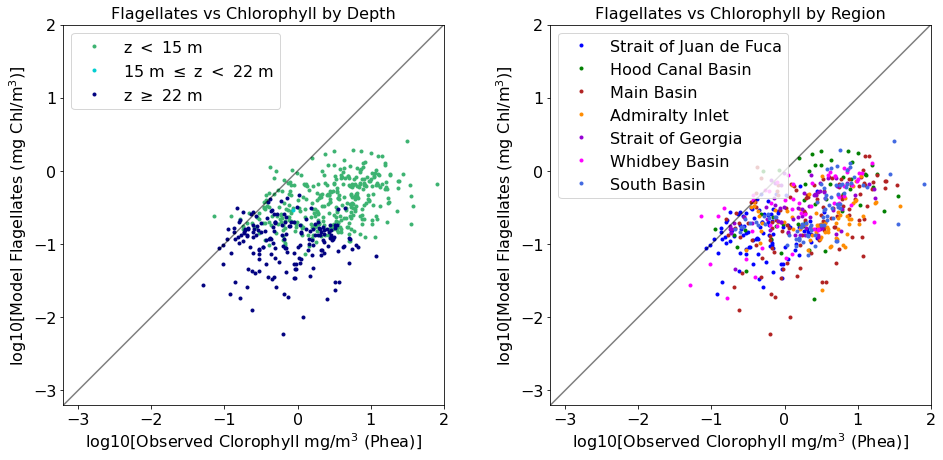

In [72]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_Phea,ax[0],obsvar,modvar,mv)
ax[0].set_title('Flagellates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]')  

ps,l=byRegion(data_Phea,datreg_Phea,ax[1],obsvar,modvar,mv)
ax[1].set_title('Flagellates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]') 

### Model flagellates vs observed Chlorophyll comparisons for multiple seasons

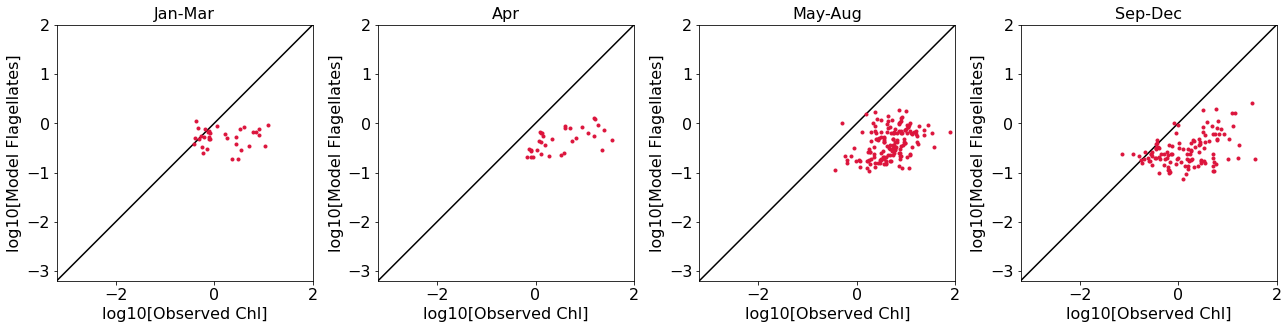

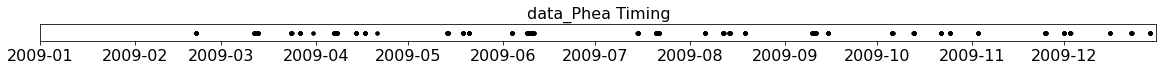

In [73]:
seasons=[JFM_Phea,Apr_Phea,MJJA_Phea,SOND_Phea]
fig, ax = plt.subplots(1,4,figsize = (18,5))
bySeason(seasons,ax,obsvar,modvar,mv)
for i in range(4):
        ax[i].set_ylabel('log10[Model Flagellates]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Phea.dtUTC,np.ones(np.shape(data_Phea.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Phea Timing')
ax.yaxis.set_visible(False)

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [74]:
obsvar='Chla_Lab'
modvar='mod_Chl'

statsDict_Chl[year]['All']=OrderedDict()
for isub in statsubs_Phea:
    statsDict_Chl[year]['All'][isub]=dict()
    var=statsDict_Chl[year]['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Phea[isub].loc[:,[obsvar]], 
                                                                     statsubs_Phea[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['All'],level='Subset',suborder=list(statsubs_Phea.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Phea)]')

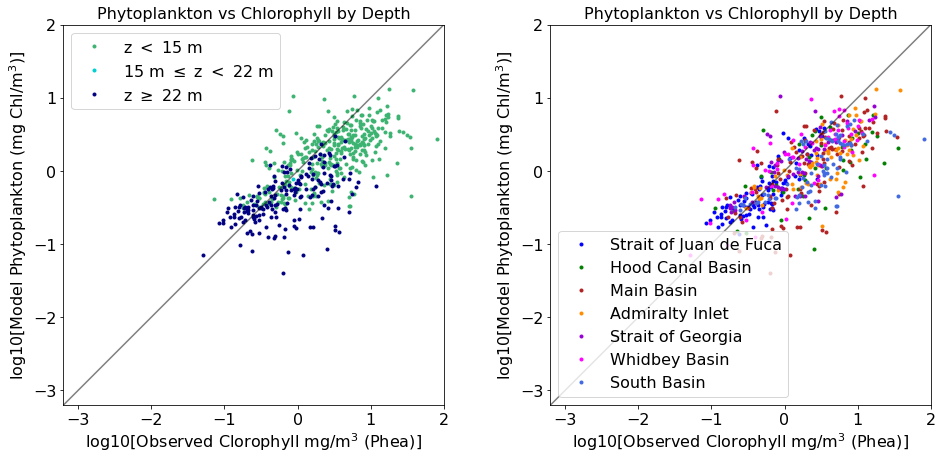

In [75]:
obsvar='log_Chl'
modvar='log_mod_Chl'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_Phea,ax[0],obsvar,modvar,mv)
ax[0].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]') 

ps,l=byRegion(data_Phea,datreg_Phea,ax[1],obsvar,modvar,mv)
ax[1].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[1].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Phea)]') 

## Model Chlorophyll vs observed Chlorophyll comparisons for multiple seasons

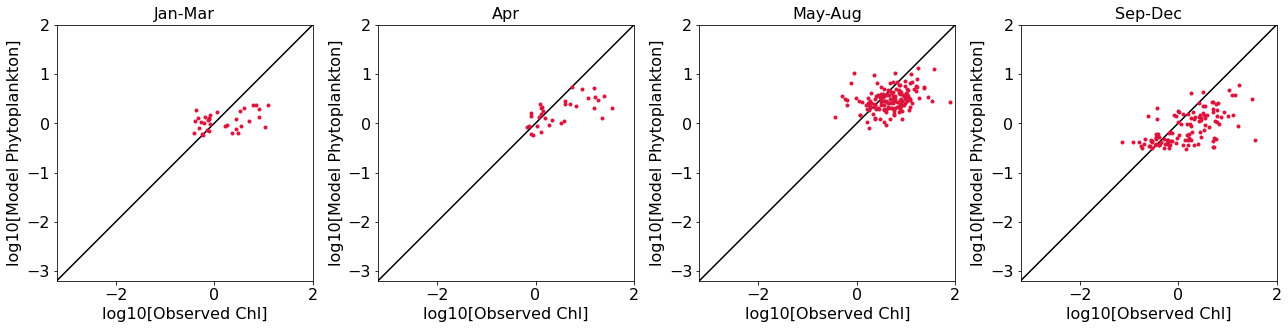

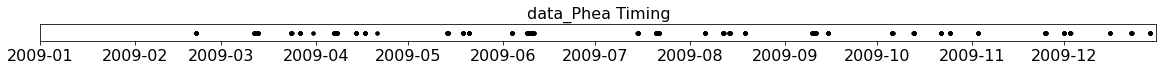

In [76]:
seasons=[JFM_Phea,Apr_Phea,MJJA_Phea,SOND_Phea]
fig, ax = plt.subplots(1,4,figsize = (18,5))
bySeason(seasons,ax,obsvar,modvar,mv)
for i in range(4):
        ax[i].set_ylabel('log10[Model Phytoplankton]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Phea.dtUTC,np.ones(np.shape(data_Phea.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Phea Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [77]:
#No longer entirely accurate, should create seperate ones for each of the chlorophyll 
#comparisons and the CT SA analysis. Also should probably not log transform for the table.
tbl,tdf=et.displayStats(statsDict_Chl[year],level='Variable',suborder=list(statsubs_Phea.keys()))
tbl